# ENCODE Subset Peaks

Given a subset of peaks, find out which cells in ENCODE have highest/lowest fraction of reads in those peaks.

In [ ]:
library(GenomicRanges)
library(DESeq2)

In [5]:
# load encode counts matrix
cts <- read.csv("/oak/stanford/groups/akundaje/projects/atlas/counts_matrices/atlas.dnase.overlap.counts.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,ENCSR000EID,ENCSR000EIE,ENCSR000EIF,ENCSR000EIG,ENCSR000EII,ENCSR000EIL,ENCSR000EIN,ENCSR000EIV,ENCSR000EIW,ENCSR000EIY,⋯,ENCSR974TXT,ENCSR976XOY,ENCSR978QUT,ENCSR979ZJS,ENCSR986HEN,ENCSR986XLW,ENCSR988YKR,ENCSR989YIV,ENCSR990XXC,ENCSR999TSD
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 10370 10641,28,9,17,8,49,28,7,11,20,33,⋯,2,1,0,3,2,12,0,15,3,1
chr1 10711 11232,12,9,5,9,44,39,2,7,13,27,⋯,0,1,0,1,1,2,0,9,1,0


[1] 2027128     622

In [6]:
encode_peaks_gr = GRanges(sub("\t", "-", sub("\t", ":", rownames(cts))))

In [7]:
head(encode_peaks_gr)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames      ranges strand
         <Rle>   <IRanges>  <Rle>
  [1]     chr1 10370-10641      *
  [2]     chr1 10711-11232      *
  [3]     chr1 11308-11533      *
  [4]     chr1 14499-14700      *
  [5]     chr1 16142-16349      *
  [6]     chr1 25958-26158      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [ ]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

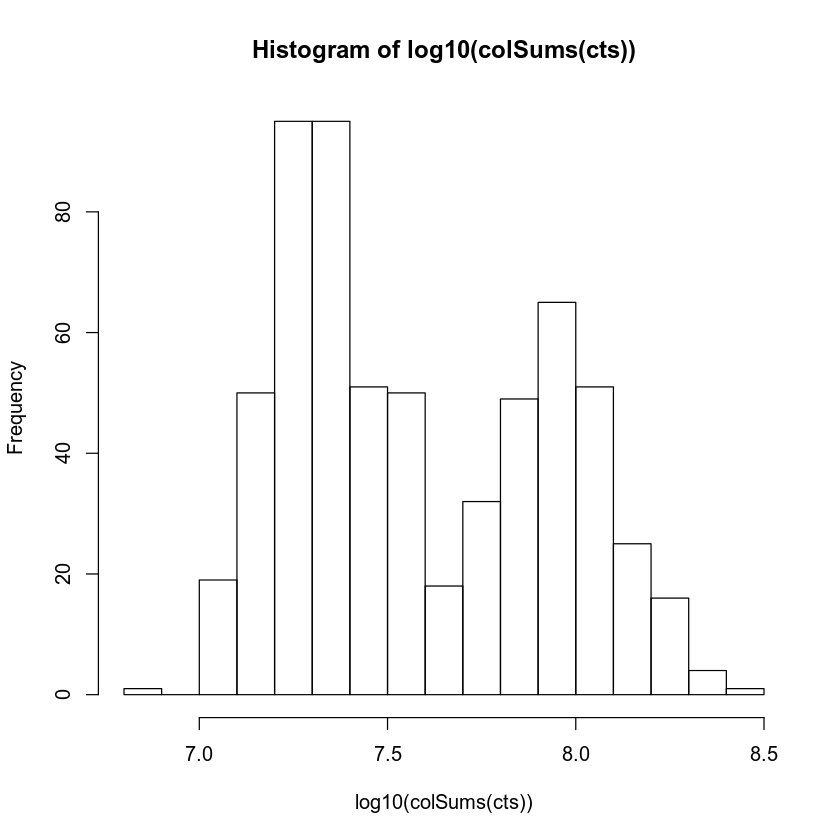

In [23]:
hist(log10(colSums(cts)))

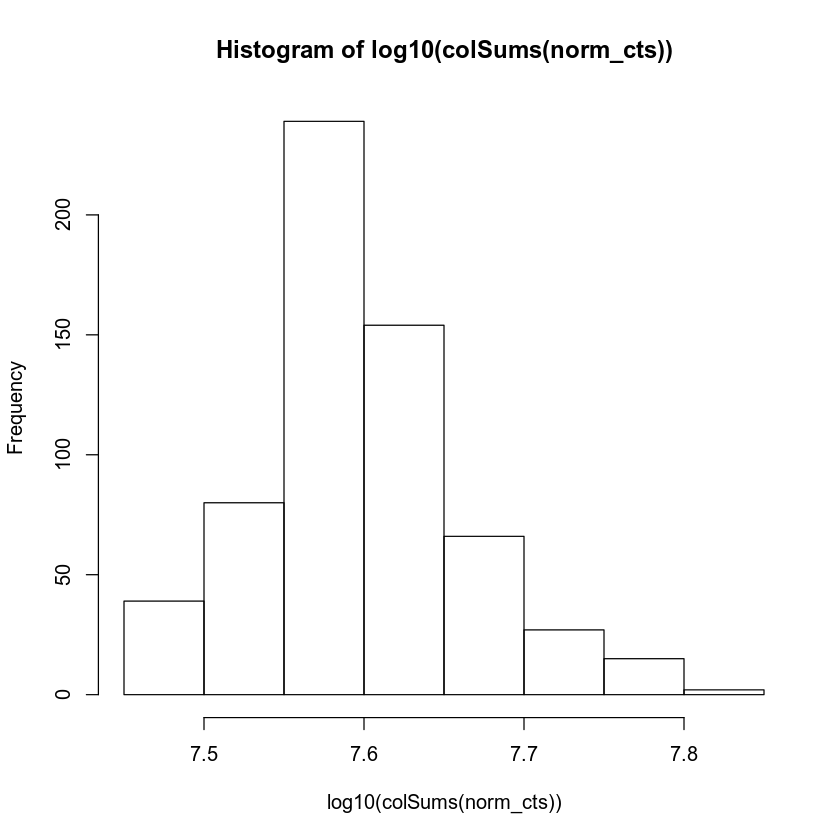

In [24]:
hist(log10(colSums(norm_cts)))

In [22]:
colnames(metadata)

[1] "Biosample.summary"   "Biosample.term.name"

In [9]:
# ENCODE metadata
metadata = read.delim("/oak/stanford/groups/akundaje/projects/atlas/dnase_experiments_metadata.tsv", 
                      sep="\t",
                     skip=1,
                     header=T,
                     fill=T)
metadata = metadata[, c("Accession", "Biosample.summary", "Biosample.term.name")]
rownames(metadata) = metadata$Accession
metadata$Accession = NULL
head(metadata)

,Biosample.summary,Biosample.term.name
,<fct>,<fct>
ENCSR728BAD,adrenal gland male embryo (108 days),adrenal gland
ENCSR724CND,foreskin keratinocyte male newborn,foreskin keratinocyte
ENCSR770DEN,fibroblast of skin of scalp male embryo (97 days),fibroblast of skin of scalp
ENCSR594OWA,small intestine male embryo (91 day),small intestine
ENCSR325LYJ,fibroblast of skin of upper back male embryo (97 days),fibroblast of skin of upper back
ENCSR257CIZ,kidney tubule cell female adult (80 years) treated with 5 μM cisplatin,kidney tubule cell


In [65]:
# ref peaks
# peak_set = read.table("./beds/20200313_heatmap_qn_D0_CC_D2_16hr_sorted_n15/idx8.bed",
peak_set = read.table("../20200307_fine_clustering/beds/20200307_gridmap_naive_n15/idx8.bed",
                      header=F, sep='')
colnames(peak_set) = c("chr", "start", "end")
peak_set = makeGRangesFromDataFrame(peak_set)
head(peak_set)

GRanges object with 6 ranges and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]     chr1 1094825-1095170      *
  [2]     chr1 1191662-1192082      *
  [3]     chr1 1222306-1222544      *
  [4]     chr1 1261227-1261590      *
  [5]     chr1 1421667-1421867      *
  [6]     chr1 1557055-1557256      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [66]:
overlaps = findOverlaps(encode_peaks_gr, peak_set)
overlaps

Hits object with 24936 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]       324           1
      [2]       415           3
      [3]       444           4
      [4]       572           5
      [5]       688           6
      ...       ...         ...
  [24932]   2025778       26963
  [24933]   2025793       26964
  [24934]   2025815       26965
  [24935]   2025822       26966
  [24936]   2026009       26967
  -------
  queryLength: 2027128 / subjectLength: 26967

In [67]:
length(unique(queryHits(overlaps)))

[1] 23922

In [68]:
frac_reads_in_peak_set = colSums(cts[unique(queryHits(overlaps)),])/colSums(cts)
norm_reads_in_peak_set = colSums(norm_cts[unique(queryHits(overlaps)),])

In [69]:
df = data.frame(nrip=norm_reads_in_peak_set,
               metadata[names(norm_reads_in_peak_set),])
df = df[rev(order(df$nrip)), c("nrip", "Biosample.term.name")]
head(df, 20)

,nrip,Biosample.term.name
,<dbl>,<fct>
ENCSR620QNS,1291725.3,HAP-1
ENCSR187PYY,945433.0,brain
ENCSR000ENO,898431.4,HeLa-S3
ENCSR309FOO,883850.9,brain
ENCSR156CLC,849142.5,brain
ENCSR724CND,798063.5,foreskin keratinocyte
ENCSR649KBB,788927.8,brain
ENCSR000EPY,780635.3,SK-N-MC
ENCSR000EON,772673.4,retinal pigment epithelial cell


In [70]:
df = data.frame(percentage=100*frac_reads_in_peak_set,
               metadata[names(frac_reads_in_peak_set),])
df = df[rev(order(df$percentage)), c("percentage", "Biosample.term.name")]
head(df, 100)

,percentage,Biosample.term.name
,<dbl>,<fct>
ENCSR620QNS,2.936823,HAP-1
ENCSR318PRQ,1.729539,middle frontal gyrus
ENCSR187PYY,1.727819,brain
ENCSR706IDL,1.702995,midbrain
ENCSR015BGH,1.698855,caudate nucleus
ENCSR420NOA,1.697262,hematopoietic multipotent progenitor cell
ENCSR000EPY,1.670449,SK-N-MC
ENCSR859CZM,1.622089,occipital lobe
ENCSR224IYD,1.609526,medulla oblongata


In [48]:
head(df[order(df$percentage), ], 20)

,percentage,Biosample.term.name
,<dbl>,<fct>
ENCSR000EQN,1.710770,WI38
ENCSR000EQM,1.864732,WI38
ENCSR562ACY,1.920067,fibroblast of skin of left biceps
ENCSR000EMG,1.932068,HS-5
ENCSR000EOI,1.935005,fibroblast of peridontal ligament
ENCSR000EMH,1.939550,stromal cell of bone marrow
ENCSR000EMA,1.945034,AG09319
ENCSR000ELY,1.950024,AG04450
ENCSR555TFE,1.957594,fibroblast of skin of left quadriceps
